In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *

In [178]:
source = pd.read_csv('dataset.csv', header=None)
U = 'u'
V = 'v'
source.columns = [U, V]
N = len(source)
source.head()

,u,v
0,405,107.5
1,521,154.9
2,382,98.1
3,362,111.7
4,444,130.0


работаем по схеме

$$ z_x = \frac{x - \bar{x}}{\sigma_x}.$$

In [179]:
normalized = source.copy()
normalized[U] = (normalized[U] - normalized[U].mean()) / normalized[U].std()
normalized[V] = (normalized[V] - normalized[V].mean()) / normalized[V].std()
normalized

,u,v
0,-0.893663,-1.027792
1,1.325225,1.241278
2,-1.333615,-1.477776
3,-1.716182,-0.826735
4,-0.147657,0.049298
...,...,...
109,1.000043,0.781720
110,0.368808,0.714701
111,0.789631,1.222130
112,1.765177,1.806152


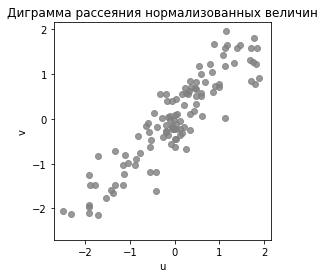

In [180]:
X_LIM = (np.min(normalized[U]) - 0.2, np.max(normalized[U]) + 0.2)
Y_LIM = (np.min(normalized[V]) - 0.2, np.max(normalized[V]) + 0.2)
LIM = (np.min([*X_LIM, *Y_LIM]), np.max([*X_LIM, *Y_LIM]))

plt.scatter(normalized[U], normalized[V], alpha=0.8, color="gray")
plt.xlabel(U)
plt.ylabel(V)
plt.title("Диграмма рассеяния нормализованных величин")
plt.xlim(LIM)
plt.ylim(LIM)
plt.gca().set_aspect('equal')
plt.show()


In [181]:
def _find_point_distances(_points, _point):
    return np.linalg.norm(
        _points[(_points != _point).apply(lambda x: x.any(), axis=1)] - _point, 
        axis=1)


def find_min_distance(_points):
    return np.min(_points.apply(
        lambda x: np.min(_find_point_distances(_points, x)),
        axis=1))


def find_max_distance(_points):
    return np.max(_points.apply(
        lambda x: np.max(_find_point_distances(_points, x)),
        axis=1))


def find_initial_center_index(_points):
    return np.argmin(_points.apply(
        lambda x: np.sum(_find_point_distances(_points, x)),
        axis=1))


In [182]:
class Cluster(object):
    def __init__(self, _points, _radius):
        self.points = _points
        self.center = _points.iloc[find_initial_center_index(_points), :]
        self.radius = _radius
        self.center_history = [self.center]

    def correct_center(self):
        _inner_points = np.linalg.norm(self.points - self.center, axis=1)  \
            <= self.radius
        _new_center = self.points[_inner_points].mean(axis=0)
        if (_new_center != self.center).any():
            self.center = _new_center
            self.center_history.append(self.center)
            return True
        return False

    def filter_inner_points(self, _center = None):
        if _center is None:
            _center = self.center
        _inner_points = np.linalg.norm(self.points - _center, axis=1)  \
            < self.radius
        return self.points[_inner_points]

    def filter_outer_points(self, _center=None):
        if _center is None:
            _center = self.center
        _inner_points = np.linalg.norm(self.points - _center, axis=1)  \
            < self.radius
        return self.points[~_inner_points]

    def f1(self):
        _inner_points = self.filter_inner_points()
        return np.sum(np.linalg.norm(_inner_points - self.center, axis=1) ** 2)

    def f2(self):
        _inner_points = self.filter_inner_points()
        _sum = 0
        for i in range(len(_inner_points) - 1):
            _sum += np.sum(np.linalg.norm(_inner_points.iloc[i+1:,:] - _inner_points.iloc[i,:], axis=1))
        return _sum

    def f3(self):
        _inner_points = self.filter_inner_points()
        return np.sum((np.array(_inner_points) - np.array(self.center)) ** 2) / len(_inner_points)

    def __str__(self):
        return '{{Center({:.4f}; {:.4f}), Points({})}}'.format(*list(self.center), len(self.filter_inner_points()))


def clusterise(_points, _r):
    _clusters = []
    while len(_points) > 0:
        _cluster = Cluster(_points, _r)
        while _cluster.correct_center():
            pass
        _clusters.append(_cluster)
        _points = _cluster.filter_outer_points()
    return _clusters


In [183]:
R_MIN = find_min_distance(normalized)
R_MAX = find_max_distance(normalized)
print("Минимальный радиус: {}, максимальный радиус: {}".format(R_MIN, R_MAX))

Минимальный радиус: 0.021390595368157756, максимальный радиус: 5.751746303724613


In [184]:
def draw_cluster_history(_cluster):
    _history = _cluster.center_history

    for center in _history:
        _ax = plt.gca()
        _inner_points = _cluster.filter_inner_points(center)
        _outer_points = _cluster.filter_outer_points(center)
        _ax.scatter(_inner_points[U],
                    _inner_points[V], alpha=0.5, color="gray")
        _ax.scatter(_outer_points[U],
                    _outer_points[V], alpha=0.2, color="gray")
        _ax.add_patch(plt.Circle(list(center), _cluster.radius, alpha=0.4))
        _ax.plot(center[U], center[V], marker="o", ms=6)

        _ax.set_xlim(LIM)
        _ax.set_ylim(LIM)
        _ax.set_aspect('equal')
        plt.show()


def visualize_clusters_history(_clusters):
    print("Сформировано кластеров: {}".format(len(_clusters)))

    i = 1
    for cluster in _clusters:
        print("Формирование {} кластера".format(i))
        draw_cluster_history(cluster)
        i += 1


def visualize_clusters(_clusters):
    plt.title("Результат кластеризации")
    for cluster in _clusters:
        _inner_points = cluster.filter_inner_points()
        plt.scatter(_inner_points[U], _inner_points[V], alpha=0.3)
        plt.plot(cluster.center[U], cluster.center[V],
                 marker="x", mew=3, ms=6)

    plt.xlim(LIM)
    plt.ylim(LIM)
    plt.gca().set_aspect('equal')
    plt.show()


def show_clusters_quality(_clusters):
    _f1 = np.sum(list(map(lambda x: x.f1(), _clusters)))
    _f2 = np.sum(list(map(lambda x: x.f2(), _clusters)))
    _f3 = np.sum(list(map(lambda x: x.f3(), _clusters)))
    print("F1: {}, F2: {}, F3: {}".format(_f1, _f2, _f3))


Выбранный радиус кластера: 0.11689652384076535
Число кластеров: 79
F1: 0.1498456974281565, F2: 5.083596865503569, F3: 0.050542186610395834


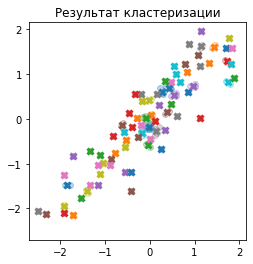

Выбранный радиус кластера: 0.21240245231337296
Число кластеров: 44
F1: 1.144487823785436, F2: 35.84831474065012, F3: 0.26573529731181916


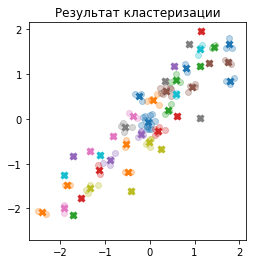

Выбранный радиус кластера: 0.30790838078598054
Число кластеров: 31
F1: 2.919667868994831, F2: 106.10693819056274, F3: 0.45489471441583396


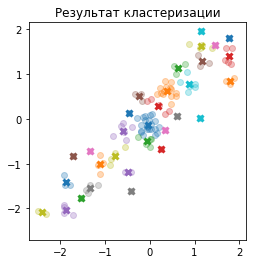

Выбранный радиус кластера: 0.4034143092585881
Число кластеров: 22
F1: 4.450114335400134, F2: 190.34063733373293, F3: 0.5219472845576381


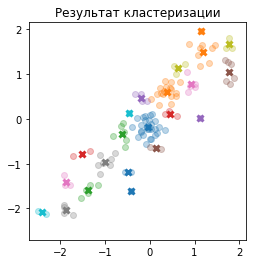

Выбранный радиус кластера: 0.4989202377311957
Число кластеров: 17
F1: 7.508712276391271, F2: 279.0524174132914, F3: 0.7577992928985263


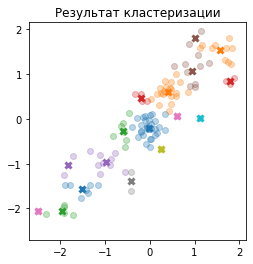

Выбранный радиус кластера: 0.5944261662038033
Число кластеров: 12
F1: 13.132416175875024, F2: 580.8517602492782, F3: 0.742871604925908


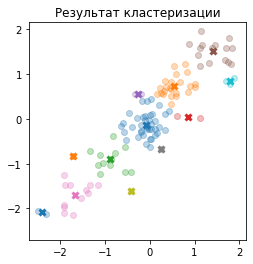

Выбранный радиус кластера: 0.6899320946764109
Число кластеров: 11
F1: 17.14281306632721, F2: 798.1919785163991, F3: 0.8115777773607646


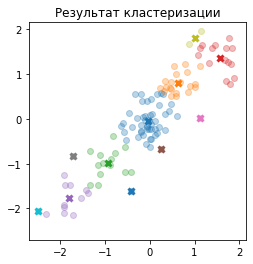

Выбранный радиус кластера: 0.7854380231490186
Число кластеров: 7
F1: 22.03630898373163, F2: 993.519619450861, F3: 0.9591392726973078


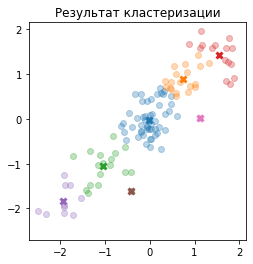

Выбранный радиус кластера: 0.8809439516216262
Число кластеров: 5
F1: 31.720934288936704, F2: 1505.2076032224682, F3: 0.9999038935764568


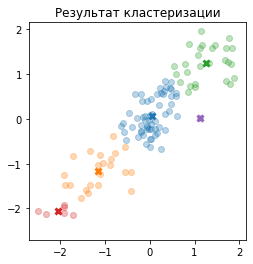

Выбранный радиус кластера: 0.9764498800942338
Число кластеров: 5
F1: 35.28609636933006, F2: 1666.604660038646, F3: 1.0179869824822763


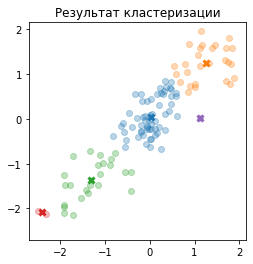

Выбранный радиус кластера: 1.0719558085668415
Число кластеров: 4
F1: 38.32866626439944, F2: 1921.4228010455267, F3: 1.0352791085740767


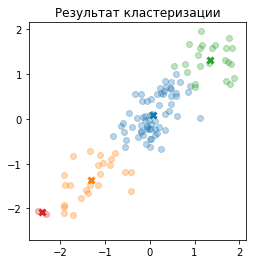

Выбранный радиус кластера: 1.167461737039449
Число кластеров: 4
F1: 41.2201386300698, F2: 2166.731069633311, F3: 1.03166683654706


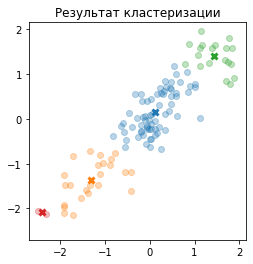

Выбранный радиус кластера: 1.2629676655120567
Число кластеров: 4
F1: 41.2201386300698, F2: 2166.731069633311, F3: 1.03166683654706


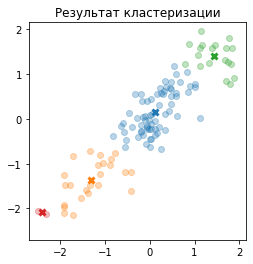

Выбранный радиус кластера: 1.3584735939846644
Число кластеров: 3
F1: 46.38686905176715, F2: 2375.949888724397, F3: 1.1217040163657148


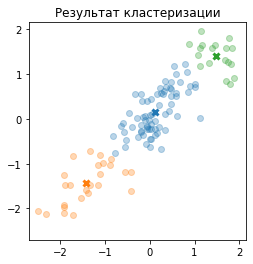

Выбранный радиус кластера: 1.453979522457272
Число кластеров: 3
F1: 49.777794098534926, F2: 2622.236333392757, F3: 1.1281027129084937


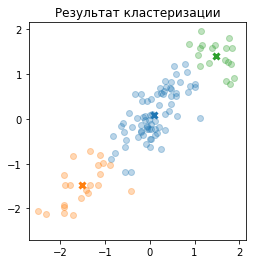

Выбранный радиус кластера: 1.5494854509298797
Число кластеров: 3
F1: 54.46167642308208, F2: 2912.5834024096052, F3: 1.1578420959964153


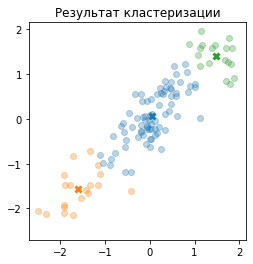

Выбранный радиус кластера: 1.6449913794024873
Число кластеров: 3
F1: 60.391126402442374, F2: 3250.8382537228763, F3: 1.1933767193176927


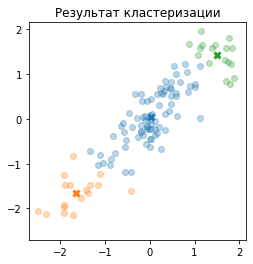

Выбранный радиус кластера: 1.740497307875095
Число кластеров: 3
F1: 64.00386126394483, F2: 3500.6395055079097, F3: 1.1495142093350659


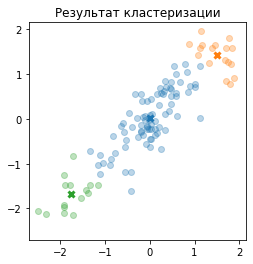

Выбранный радиус кластера: 1.8360032363477026
Число кластеров: 3
F1: 69.97796948394708, F2: 3781.172779299121, F3: 1.2167931214363117


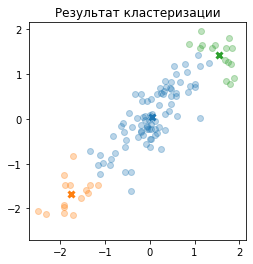

Выбранный радиус кластера: 1.9315091648203102
Число кластеров: 3
F1: 85.02244761828676, F2: 4557.941988888543, F3: 1.2847435937026443


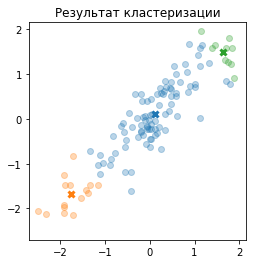

Выбранный радиус кластера: 2.027015093292918
Число кластеров: 3
F1: 110.04543843469068, F2: 5829.562909433919, F3: 1.3712208558387187


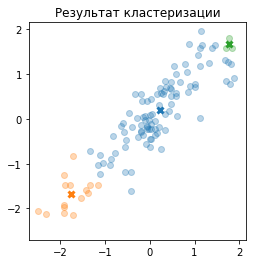

Выбранный радиус кластера: 2.1225210217655253
Число кластеров: 3
F1: 118.50417576113689, F2: 6237.267238711683, F3: 1.4224780662903265


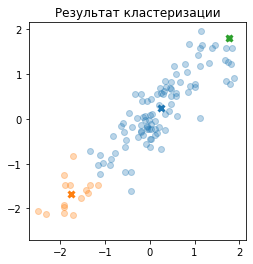

Выбранный радиус кластера: 2.2180269502381327
Число кластеров: 3
F1: 126.98483987339819, F2: 6659.845847464388, F3: 1.4377015706821326


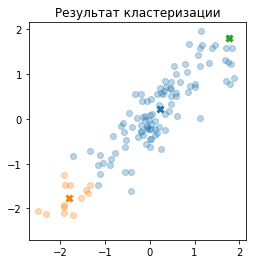

Выбранный радиус кластера: 2.31353287871074
Число кластеров: 2
F1: 136.84193129775392, F2: 7114.7850526322, F3: 1.5009579110496678


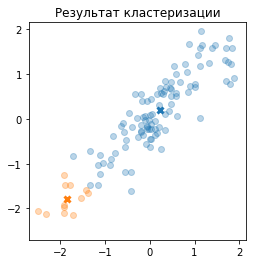

Выбранный радиус кластера: 2.4090388071833475
Число кластеров: 2
F1: 142.45307158700226, F2: 7359.117058313767, F3: 1.5390452293930486


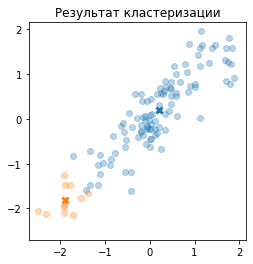

Выбранный радиус кластера: 2.504544735655955
Число кластеров: 2
F1: 148.00879659155947, F2: 7606.035528429268, F3: 1.5691134751428617


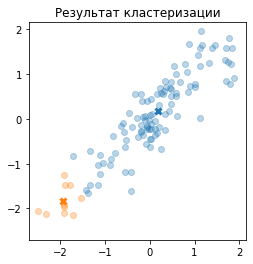

Выбранный радиус кластера: 2.6000506641285623
Число кластеров: 2
F1: 172.85184221649087, F2: 8682.924553952053, F3: 1.6757524689240204


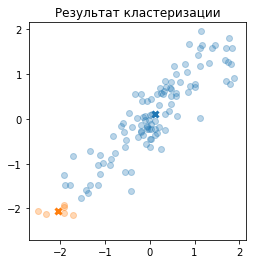

Выбранный радиус кластера: 2.6955565926011698
Число кластеров: 2
F1: 172.85184221649087, F2: 8682.924553952053, F3: 1.6757524689240204


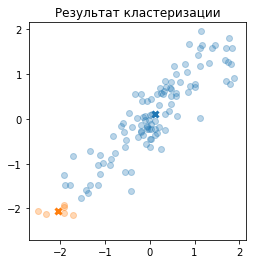

Выбранный радиус кластера: 2.791062521073777
Число кластеров: 2
F1: 172.85184221649087, F2: 8682.924553952053, F3: 1.6757524689240204


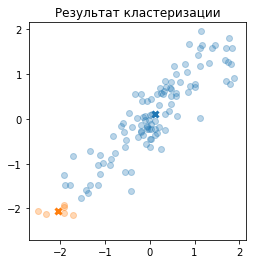

Выбранный радиус кластера: 2.8865684495463846
Число кластеров: 2
F1: 197.0269366534956, F2: 9624.690798083817, F3: 1.835367103580148


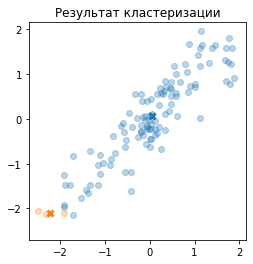

Выбранный радиус кластера: 2.982074378018992
Число кластеров: 2
F1: 205.35104349730807, F2: 9951.091941547811, F3: 1.8437414598699113


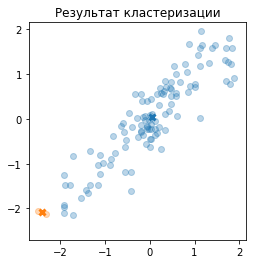

Выбранный радиус кластера: 3.0775803064915994
Число кластеров: 2
F1: 205.35104349730807, F2: 9951.091941547811, F3: 1.8437414598699113


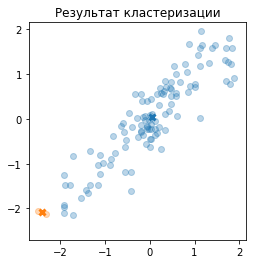

Выбранный радиус кластера: 3.173086234964207
Число кластеров: 2
F1: 215.4435575160627, F2: 10310.854664875802, F3: 1.9065801550094041


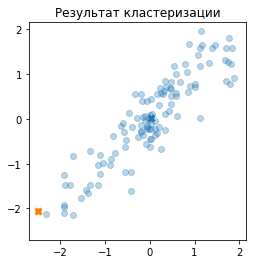

Выбранный радиус кластера: 3.2685921634368142
Число кластеров: 1
F1: 225.99999999999994, F2: 10682.299932105065, F3: 1.9824561403508771


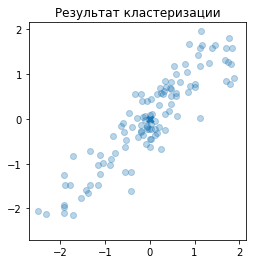

In [188]:
STEP = (R_MAX - R_MIN) / 60
r = R_MIN + STEP
while r < R_MAX:
    print("Выбранный радиус кластера: {}".format(r))
    _clusters = clusterise(normalized, r)
    #visualize_clusters_history(_clusters)
    print("Число кластеров: {}".format(len(_clusters)))
    show_clusters_quality(_clusters)
    visualize_clusters(_clusters)
    r += STEP
    if len(_clusters) == 1:
        break
